In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from fbprophet import Prophet

# Functions

In [2]:
# function to run Prophet and return the forecast
def ProphetForecast(df_input):
    m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
    m.fit(df_input)
    # find how many periods we need by finding the last day in the item
    days_to_predict = pd.to_datetime('2016-1-31') - df_input['ds'].max()
    future = m.make_future_dataframe(periods=days_to_predict.days)
    future['floor'] = df_input['y'].min()
    future['cap'] = df_input['y'].max()
    forecast = m.predict(future)
    return m, forecast

# Load Data

In [3]:
df_sales = pd.read_csv('../data/sales_train_v2.csv')

#  Data Cleaning

In [4]:
# make date-time format use day first
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [5]:
# remove 0 or negative item count
df_sales = df_sales.loc[df_sales['item_cnt_day']>0]

In [6]:
# Replace negative price with mean.  There is only 1 item with a negative price, item 2973
mean = int(df_sales.loc[df_sales['item_id']==2973, 'item_price'].mean())
df_sales["item_price"] = df_sales["item_price"].mask(df_sales["item_price"] <0, mean)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [7]:
# Get sales data only for items had sales after 2015-05-01
df_sales_recent = df_sales[df_sales.date > '2015-05-01']
df_item1 = df_sales_recent.drop(['date', 'date_block_num','shop_id','item_price','item_cnt_day'], axis=1)
df_item2=df_item1.drop_duplicates()

In [8]:
df_sales_recent_6m = pd.merge(left=df_item2,right=df_sales, how='left', on='item_id')

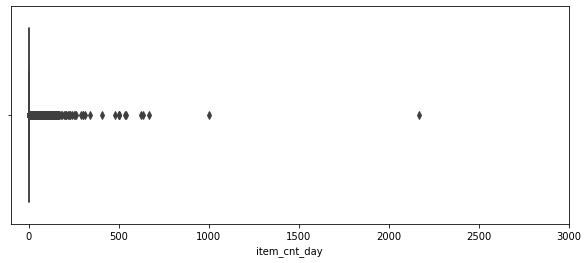

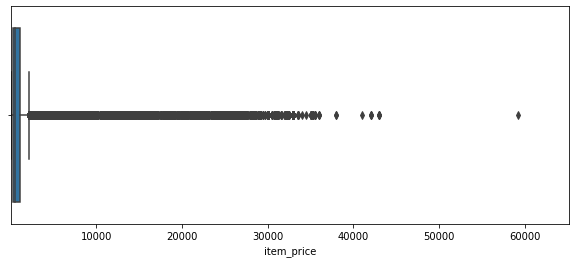

In [9]:
# Outlier exploration
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_sales_recent_6m.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(df_sales_recent_6m.item_price.min(), df_sales_recent_6m.item_price.max()*1.1)
sns.boxplot(x=df_sales_recent_6m.item_price)

In [10]:
# Remove outliers on Price
# Sales data for all items that have sales in the last 6 months
df_sales_clean_all_items = df_sales_recent_6m[df_sales_recent_6m.item_price<40000]
# rename columns now to improve speed in loop
df_sales_clean_all_items = df_sales_clean_all_items.rename(columns={"date": "ds"})
df_sales_clean_all_items

,item_id,ds,date_block_num,shop_id,item_price,item_cnt_day
0,15710,2013-04-30,3,25,349.0,1.0
1,15710,2013-04-27,3,25,349.0,4.0
2,15710,2013-04-26,3,25,349.0,1.0
3,15710,2013-04-25,3,25,349.0,2.0
4,15710,2013-04-27,3,21,349.0,1.0
...,...,...,...,...,...,...
2112327,7610,2015-10-29,33,25,2890.0,1.0
2112328,7635,2015-10-22,33,25,2100.0,1.0
2112329,7638,2015-01-18,24,25,1660.0,1.0
2112330,7638,2015-10-30,33,25,1890.0,1.0


# Create dataframe of most sold items

In [11]:
# find the most sold items
df_sales_totalitem = df_sales_clean_all_items.groupby(['item_id'])['item_cnt_day'].sum().reset_index(name='item_cnt_total')
df_sales_totalitem = df_sales_totalitem.sort_values(by='item_cnt_total',ascending=False)
df_sales_totalitem.head(10)

,item_id,item_cnt_total
8373,20949,187660.0
1128,2808,17255.0
1547,3732,16676.0
7125,17717,15830.0
2423,5822,14522.0
1549,3734,11733.0
2733,6675,10315.0
1546,3731,10105.0
754,1855,10041.0
6815,16787,9255.0


# Predict and Plot Top 5 items

To test our model, the top 5 most sold items will be predicted then plotted here.

## Item 20949, most sold item

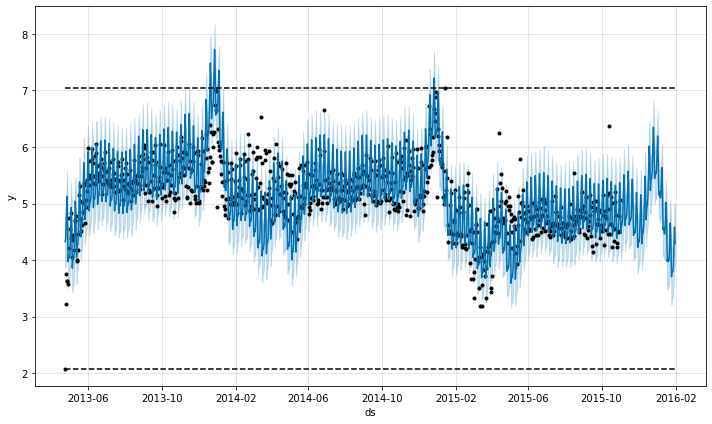

In [12]:
item_to_predict = 20949
# create df for prophet
df_fbprophet = df_sales_clean_all_items.loc[
    (df_sales_clean_all_items['item_id']==item_to_predict)]
# sum the total sold for each day for this item
df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

# convert to log scale
df_fbprophet['y'] = np.log(df_fbprophet['y'])

df_fbprophet['floor']=df_fbprophet['y'].min()
df_fbprophet['cap']=df_fbprophet['y'].max()
m, forecast = ProphetForecast(df_fbprophet)
fig1 = m.plot(forecast)

## Item 2808, Exponentially decreasing sales

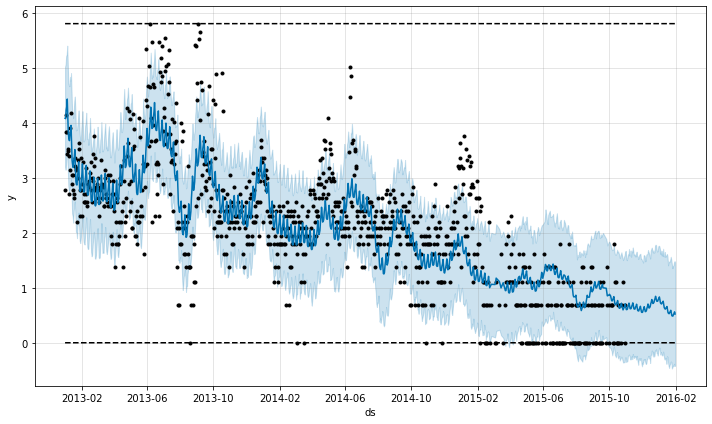

In [13]:
item_to_predict = 2808
# create df for prophet
df_fbprophet = df_sales_clean_all_items.loc[
    (df_sales_clean_all_items['item_id']==item_to_predict)]
# sum the total sold for each day for this item
df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

# convert to log scale
df_fbprophet['y'] = np.log(df_fbprophet['y'])

df_fbprophet['floor']=df_fbprophet['y'].min()
df_fbprophet['cap']=df_fbprophet['y'].max()
m, forecast = ProphetForecast(df_fbprophet)
fig1 = m.plot(forecast)

## Item 3732: Exponentially Decreasing Sales

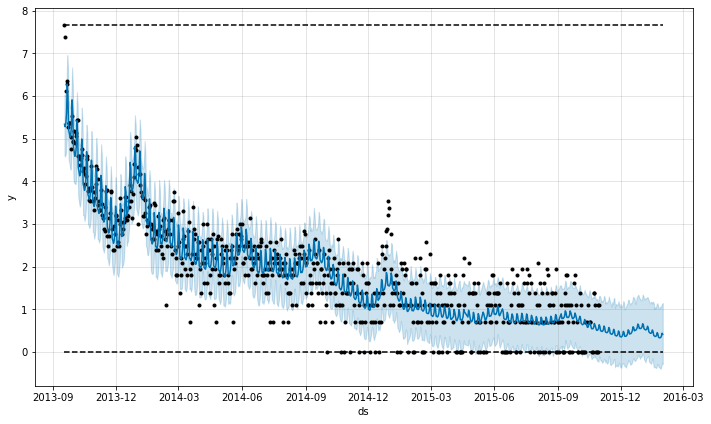

In [14]:
item_to_predict = 3732
# create df for prophet
df_fbprophet = df_sales_clean_all_items.loc[
    (df_sales_clean_all_items['item_id']==item_to_predict)]
# sum the total sold for each day for this item
df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

# convert to log scale
df_fbprophet['y'] = np.log(df_fbprophet['y'])

df_fbprophet['floor']=df_fbprophet['y'].min()
df_fbprophet['cap']=df_fbprophet['y'].max()
m, forecast = ProphetForecast(df_fbprophet)
fig1 = m.plot(forecast)

## Item 17717: Unpredictable sales trend

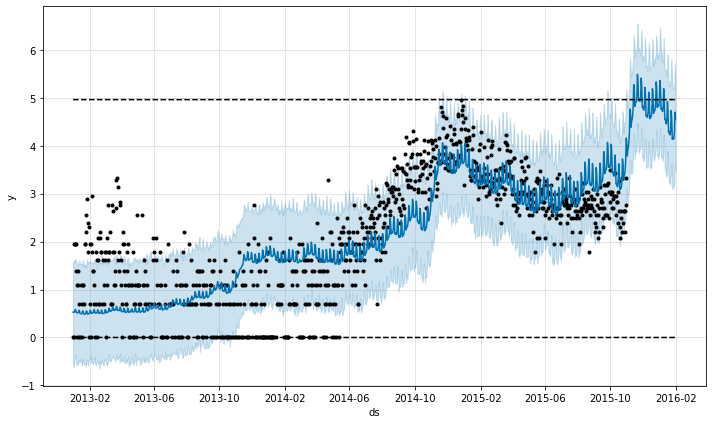

In [15]:
item_to_predict = 17717
# create df for prophet
df_fbprophet = df_sales_clean_all_items.loc[
    (df_sales_clean_all_items['item_id']==item_to_predict)]
# sum the total sold for each day for this item
df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

# convert to log scale
df_fbprophet['y'] = np.log(df_fbprophet['y'])

df_fbprophet['floor']=df_fbprophet['y'].min()
df_fbprophet['cap']=df_fbprophet['y'].max()
m, forecast = ProphetForecast(df_fbprophet)
fig1 = m.plot(forecast)

The predicted trend (blue line) starts to diverge from the data (black dots) around 2015-07.  There seems to be a lot of noise in this data that makes it hard to predict, even for a human, I'm not sure if the trend will do up or down in 2015-11 compared to 2015-10!

## Item 5822: Noisy data with some seasonality

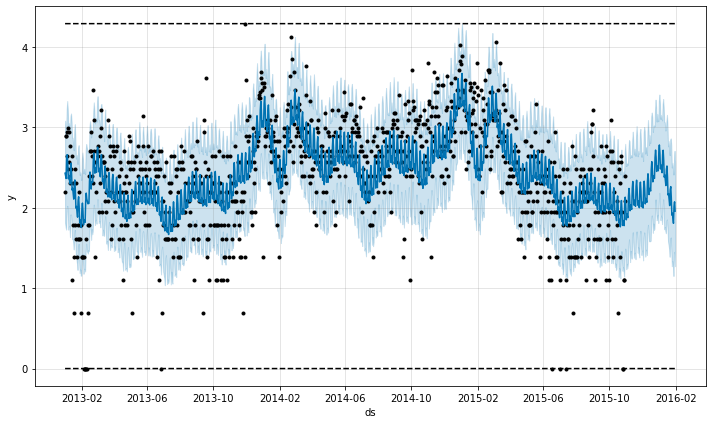

In [16]:
item_to_predict = 5822
# create df for prophet
df_fbprophet = df_sales_clean_all_items.loc[
    (df_sales_clean_all_items['item_id']==item_to_predict)]
# sum the total sold for each day for this item
df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

# convert to log scale
df_fbprophet['y'] = np.log(df_fbprophet['y'])

df_fbprophet['floor']=df_fbprophet['y'].min()
df_fbprophet['cap']=df_fbprophet['y'].max()
m, forecast = ProphetForecast(df_fbprophet)
fig1 = m.plot(forecast)

There is some seasonality here, but there is no clear overall trend.  We can see there is a seasonality dip in 2013-02, 2014-02, and 2015-02, likely coinciding with the slow-down after Christmas shopping.  The model used is still able to reasonably predict 2015-11.

# RMSE Calculation Loop

In [17]:

# iterate through top 10
total_rmse = 0
total_rmse_exclude_17717 = 0
number_of_items_to_predict = 10
for index, row in df_sales_totalitem.head(number_of_items_to_predict).iterrows():
    # create df for prophet
    df_fbprophet = df_sales_clean_all_items.loc[
        (df_sales_clean_all_items['item_id']==row['item_id'])&
        (df_sales_clean_all_items['ds']<pd.to_datetime('2015-10-1'))]
    # sum the total sold for each day for this item
    df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

    # convert to log scale
    df_fbprophet['y'] = np.log(df_fbprophet['y'])

    df_fbprophet['floor']=df_fbprophet['y'].min()
    df_fbprophet['cap']=df_fbprophet['y'].max()
    m, forecast = ProphetForecast(df_fbprophet)
    # forecast for the whole month of October
    item_cnt_oct2015 = np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-10-1'))
                             & (forecast['ds']<=pd.to_datetime('2015-10-31'))]['yhat'])
    # real Oct 2015
    item_cnt_real_oct2015 = (df_sales_clean_all_items.loc[
                            (df_sales_clean_all_items['ds']>=pd.to_datetime('2015-10-1')) 
                             & (df_sales_clean_all_items['ds']<=pd.to_datetime('2015-10-31'))
                             & (df_sales_clean_all_items['item_id']==row['item_id'])]
                             .groupby(['ds'])['item_cnt_day'].fillna(0).sum())
    error = np.absolute(item_cnt_real_oct2015.sum() - item_cnt_oct2015.sum())
    total_rmse = total_rmse + (np.power(item_cnt_real_oct2015.sum() - item_cnt_oct2015.sum(), 2))
    if row['item_id'] != 17717:
        total_rmse_exclude_17717 = total_rmse_exclude_17717 + (np.power(item_cnt_real_oct2015.sum() - item_cnt_oct2015.sum(), 2))
    
    print('item_id: ' + str(row['item_id']) + ', total items:' + str(row['item_cnt_total']), end="")
    print(', Oct 2015 forecast: ' + str(round(item_cnt_oct2015.sum(), 1)), end="")
    print(', Oct 2015 real: ' + str(round(item_cnt_real_oct2015.sum(), 1)), end="")
    print(', absolute error: ' + str(round(error, 1)))

print ('total rmse for top ' + str(number_of_items_to_predict) + ' items: ' 
       + str(round(np.sqrt(total_rmse/number_of_items_to_predict),1)))
print ('total rmse for top ' + str(number_of_items_to_predict-1) + ' items excluding 17717: ' 
       + str(round(np.sqrt(total_rmse_exclude_17717/(number_of_items_to_predict-1)),1)))

item_id: 20949.0, total items:187660.0, Oct 2015 forecast: 3860.5, Oct 2015 real: 4078.0, absolute error: 217.5
item_id: 2808.0, total items:17255.0, Oct 2015 forecast: 66.3, Oct 2015 real: 40.0, absolute error: 26.3
item_id: 3732.0, total items:16676.0, Oct 2015 forecast: 58.8, Oct 2015 real: 46.0, absolute error: 12.8
item_id: 17717.0, total items:15830.0, Oct 2015 forecast: 4583.8, Oct 2015 real: 521.0, absolute error: 4062.8
item_id: 5822.0, total items:14522.0, Oct 2015 forecast: 236.5, Oct 2015 real: 259.0, absolute error: 22.5
item_id: 3734.0, total items:11733.0, Oct 2015 forecast: 61.5, Oct 2015 real: 58.0, absolute error: 3.5
item_id: 6675.0, total items:10315.0, Oct 2015 forecast: 31.5, Oct 2015 real: 2.0, absolute error: 29.5
item_id: 3731.0, total items:10105.0, Oct 2015 forecast: 144.2, Oct 2015 real: 235.0, absolute error: 90.8
item_id: 1855.0, total items:10041.0, Oct 2015 forecast: 78.8, Oct 2015 real: 5.0, absolute error: 73.8
item_id: 16787.0, total items:9255.0, Oct

We found that the Prophet method using log scaling has good performance (small errors) in most cases, but failed to provide a good prediction for item 17717 since that item's curve is more unpredictable.

# Submission Loop starts here

In [18]:
# create a submission dataframe
submission = pd.DataFrame([], columns=['item_id', 'item_cnt_month'])
submission

,item_id,item_cnt_month


In [19]:
subplot_index = 1
    
# iterate through top 10
number_of_items_to_predict = 10
for index, row in df_sales_totalitem.head(number_of_items_to_predict).iterrows():
    # create df for prophet
    df_fbprophet = df_sales_clean_all_items.loc[(df_sales_clean_all_items['item_id']==row['item_id'])]
    # sum the total sold for each day for this item
    df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

    # convert to log scale
    df_fbprophet['y'] = np.log(df_fbprophet['y'])

    df_fbprophet['floor']=df_fbprophet['y'].min()
    df_fbprophet['cap']=df_fbprophet['y'].max()
    m, forecast = ProphetForecast(df_fbprophet)
    # forecast for the whole month of November
    item_cnt_nov2015 = np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1')) 
                             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()
    print('item_id: ' + str(row['item_id']) + ', total items:' + str(row['item_cnt_total']), end="")
    print(', Nov 2015 forecast: ' + str(round(item_cnt_nov2015, 1)))
    # make a new row in submission with the item_id
    submission.loc[len(submission)] = [row['item_id'], round(item_cnt_nov2015, 1)]


item_id: 20949.0, total items:187660.0, Nov 2015 forecast: 4096.7
item_id: 2808.0, total items:17255.0, Nov 2015 forecast: 56.9
item_id: 3732.0, total items:16676.0, Nov 2015 forecast: 48.0
item_id: 17717.0, total items:15830.0, Nov 2015 forecast: 3822.9
item_id: 5822.0, total items:14522.0, Nov 2015 forecast: 246.4
item_id: 3734.0, total items:11733.0, Nov 2015 forecast: 49.8
item_id: 6675.0, total items:10315.0, Nov 2015 forecast: 30.6
item_id: 3731.0, total items:10105.0, Nov 2015 forecast: 66.1
item_id: 1855.0, total items:10041.0, Nov 2015 forecast: 69.4
item_id: 16787.0, total items:9255.0, Nov 2015 forecast: 46.6


In [20]:
submission

,item_id,item_cnt_month
0,20949.0,4096.7
1,2808.0,56.9
2,3732.0,48.0
3,17717.0,3822.9
4,5822.0,246.4
5,3734.0,49.8
6,6675.0,30.6
7,3731.0,66.1
8,1855.0,69.4
9,16787.0,46.6


In [21]:
submission.to_csv('../data/submission.csv', index=False)